In [1]:
import os, json, csv, random
from shapely import wkt
import numpy as np
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
def upscale_and_tile_one_image(
    input_jpg_path,
    input_csv_path,
    output_images_dir,
    output_csv_dir,
    upscale_factor=2,
    tile_width=1024,
    tile_height=512,
    sample_rate=1.0,      # Probability [0..1] of keeping a tile
    skip_empty_tiles=True # If True, tiles with 0 boxes are not saved
):
    """
    Processes a single image + CSV pair:
      1) Upscales the image (width & height * upscale_factor)
      2) Upscales the bounding box coords by the same factor
      3) Splits the upscaled image into tiles of (tile_width x tile_height)
      4) Clips + shifts bounding boxes that intersect each tile
      5) Saves the tile image to output_images_dir and CSV to output_csv_dir
         if it has at least 1 box (and skip_empty_tiles=True) or if sample_rate is met.
    
    This function is called by phase_two_batch() for each image/CSV pair.
    """

    # 1) Read the original image
    img = Image.open(input_jpg_path)
    orig_width, orig_height = img.size

    # 2) Upscale the image
    upscaled_width = int(orig_width * upscale_factor)
    upscaled_height = int(orig_height * upscale_factor)
    upscaled_img = img.resize((upscaled_width, upscaled_height), Image.BICUBIC)

    # 3) Read & upscale bounding boxes
    boxes = []
    with open(input_csv_path, 'r', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            feature_type = row["feature_type"]
            x_min = float(row["x_min"]) * upscale_factor
            y_min = float(row["y_min"]) * upscale_factor
            x_max = float(row["x_max"]) * upscale_factor
            y_max = float(row["y_max"]) * upscale_factor

            boxes.append({
                "feature_type": feature_type,
                "x_min": x_min,
                "y_min": y_min,
                "x_max": x_max,
                "y_max": y_max
            })

    # 4) Determine how many tiles horizontally/vertically
    n_tiles_x = upscaled_width // tile_width   # e.g. 2048 // 1024 = 2
    n_tiles_y = upscaled_height // tile_height # e.g. 2048 // 512  = 4

    # For naming: base name + _a, _b, etc.
    base_name = os.path.splitext(os.path.basename(input_jpg_path))[0]

    def tile_suffix(tile_index):
        # Convert 0->'a', 1->'b', etc.
        return chr(ord('a') + tile_index)

    # 5) Loop over tiles
    tile_counter = 0
    for row_idx in range(n_tiles_y):
        for col_idx in range(n_tiles_x):
            # Decide if we skip this tile based on sample_rate
            if sample_rate < 1.0 and (random.random() > sample_rate):
                continue

            # Coordinates in the upscaled image
            left   = col_idx * tile_width
            upper  = row_idx * tile_height
            right  = left + tile_width
            lower  = upper + tile_height

            # Crop the tile
            tile_img = upscaled_img.crop((left, upper, right, lower))

            # Clip/shift boxes for this tile
            tile_boxes = []
            for box in boxes:
                bx_min = box["x_min"]
                bx_max = box["x_max"]
                by_min = box["y_min"]
                by_max = box["y_max"]

                # Check intersection with tile
                if (bx_min < right and bx_max > left and
                    by_min < lower and by_max > upper):
                    
                    # Clip coords
                    clipped_x_min = max(bx_min, left)
                    clipped_x_max = min(bx_max, right)
                    clipped_y_min = max(by_min, upper)
                    clipped_y_max = min(by_max, lower)

                    # Validate after clipping
                    if clipped_x_min < clipped_x_max and clipped_y_min < clipped_y_max:
                        # Shift to tile-local coords (0,0 in top-left)
                        shift_x_min = clipped_x_min - left
                        shift_x_max = clipped_x_max - left
                        shift_y_min = clipped_y_min - upper
                        shift_y_max = clipped_y_max - upper

                        tile_boxes.append({
                            "feature_type": box["feature_type"],
                            "x_min": shift_x_min,
                            "y_min": shift_y_min,
                            "x_max": shift_x_max,
                            "y_max": shift_y_max
                        })

            # Optionally skip if no boxes
            if skip_empty_tiles and len(tile_boxes) == 0:
                continue

            # Generate suffix for the tile
            suffix = tile_suffix(tile_counter)
            tile_counter += 1

            # File name for the tile image
            tile_img_name = f"{base_name}_{suffix}.jpg"
            tile_img_path = os.path.join(output_images_dir, tile_img_name)

            # File name for the tile CSV
            tile_csv_name = f"{base_name}_{suffix}.csv"
            tile_csv_path = os.path.join(output_csv_dir, tile_csv_name)

            # Save tile image
            tile_img.save(tile_img_path, 'JPEG')

            # Save tile CSV
            with open(tile_csv_path, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(["feature_type", "x_min", "y_min", "x_max", "y_max"])
                for tb in tile_boxes:
                    writer.writerow([
                        tb["feature_type"],
                        f"{tb['x_min']:.1f}",
                        f"{tb['y_min']:.1f}",
                        f"{tb['x_max']:.1f}",
                        f"{tb['y_max']:.1f}"
                    ])

            print(f"Saved tile image: {tile_img_path} with {len(tile_boxes)} boxes")


def phase_two_batch(
    input_images_dir,
    input_csv_dir,
    output_images_dir,
    output_csv_dir,
    upscale_factor=2,
    tile_width=1024,
    tile_height=512,
    sample_rate=1.0,
    skip_empty_tiles=True
):
    """
    Main Phase 2 driver:
      - Loops over all .jpg in input_images_dir
      - Finds matching CSV in input_csv_dir
      - Upscales and tiles, then saves results to output_images_dir + output_csv_dir
    """
    # Ensure output dirs exist
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_csv_dir, exist_ok=True)

    # Iterate over all JPGs in the input_images_dir
    for fname in os.listdir(input_images_dir):
        if fname.lower().endswith('.jpg'):
            # Build paths for input image and corresponding CSV
            base_name = os.path.splitext(fname)[0]
            input_jpg_path = os.path.join(input_images_dir, fname)
            
            # Matching CSV file name
            csv_fname = f"{base_name}.csv"
            input_csv_path = os.path.join(input_csv_dir, csv_fname)

            # Check if the CSV exists
            if not os.path.exists(input_csv_path):
                print(f"WARNING: No matching CSV for {input_jpg_path}. Skipping.")
                continue
            
            # Process this one image+csv pair
            upscale_and_tile_one_image(
                input_jpg_path=input_jpg_path,
                input_csv_path=input_csv_path,
                output_images_dir=output_images_dir,
                output_csv_dir=output_csv_dir,
                upscale_factor=upscale_factor,
                tile_width=tile_width,
                tile_height=tile_height,
                sample_rate=sample_rate,
                skip_empty_tiles=skip_empty_tiles
            )


In [12]:
def upscale_and_tile_one_image(
    input_jpg_path,
    input_csv_path,
    output_images_dir,
    output_csv_dir,
    output_yolo_dir,
    upscale_factor=2,
    tile_width=1024,
    tile_height=512,
    sample_rate=1.0,      # Probability [0..1] of keeping a tile
    skip_empty_tiles=True # If True, tiles with 0 "building" boxes are not saved
):
    """
    Processes a single image + CSV pair:
      1) Upscales the image (width & height * upscale_factor)
      2) Upscales bounding box coords by the same factor
      3) Splits the upscaled image into tiles of (tile_width x tile_height)
      4) Clips + shifts bounding boxes that intersect each tile
      5) Saves:
         - The tile image to output_images_dir
         - The tile bounding boxes to output_csv_dir (as CSV)
         - The tile bounding boxes in YOLO format (class x_center y_center w h)
           to output_yolo_dir as .txt files
         if it has at least 1 "building" box.
    """

    # 1) Read the original image
    img = Image.open(input_jpg_path)
    orig_width, orig_height = img.size

    # 2) Upscale the image
    upscaled_width = int(orig_width * upscale_factor)
    upscaled_height = int(orig_height * upscale_factor)
    upscaled_img = img.resize((upscaled_width, upscaled_height), Image.BICUBIC)

    # 3) Read & upscale bounding boxes
    boxes = []
    with open(input_csv_path, 'r', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            feature_type = row["feature_type"]
            x_min = float(row["x_min"]) * upscale_factor
            y_min = float(row["y_min"]) * upscale_factor
            x_max = float(row["x_max"]) * upscale_factor
            y_max = float(row["y_max"]) * upscale_factor

            boxes.append({
                "feature_type": feature_type,
                "x_min": x_min,
                "y_min": y_min,
                "x_max": x_max,
                "y_max": y_max
            })

    # 4) Determine how many tiles horizontally/vertically
    n_tiles_x = upscaled_width // tile_width   # e.g. 2048 // 1024 = 2
    n_tiles_y = upscaled_height // tile_height # e.g. 2048 // 512  = 4

    # For naming: base name + _a, _b, etc.
    base_name = os.path.splitext(os.path.basename(input_jpg_path))[0]

    def tile_suffix(tile_index):
        # Convert 0->'a', 1->'b', etc.
        return chr(ord('a') + tile_index)

    # 5) Loop over tiles
    tile_counter = 0
    for row_idx in range(n_tiles_y):
        for col_idx in range(n_tiles_x):
            # Decide if we skip this tile based on sample_rate
            if sample_rate < 1.0 and (random.random() > sample_rate):
                continue

            # Coordinates in the upscaled image
            left   = col_idx * tile_width
            upper  = row_idx * tile_height
            right  = left + tile_width
            lower  = upper + tile_height

            # Crop the tile
            tile_img = upscaled_img.crop((left, upper, right, lower))

            # Clip/shift boxes for this tile
            tile_boxes = []
            for box in boxes:
                bx_min = box["x_min"]
                bx_max = box["x_max"]
                by_min = box["y_min"]
                by_max = box["y_max"]

                # Check intersection with tile
                if (bx_min < right and bx_max > left and
                    by_min < lower and by_max > upper):
                    
                    # Clip coords
                    clipped_x_min = max(bx_min, left)
                    clipped_x_max = min(bx_max, right)
                    clipped_y_min = max(by_min, upper)
                    clipped_y_max = min(by_max, lower)

                    # Validate after clipping
                    if clipped_x_min < clipped_x_max and clipped_y_min < clipped_y_max:
                        # Shift to tile-local coords (0,0 in top-left)
                        shift_x_min = clipped_x_min - left
                        shift_x_max = clipped_x_max - left
                        shift_y_min = clipped_y_min - upper
                        shift_y_max = clipped_y_max - upper

                        tile_boxes.append({
                            "feature_type": box["feature_type"],
                            "x_min": shift_x_min,
                            "y_min": shift_y_min,
                            "x_max": shift_x_max,
                            "y_max": shift_y_max
                        })

            # Filter only "building" boxes. YOLO needs class 0 for these.
            building_boxes = [b for b in tile_boxes if b["feature_type"].lower() == "building"]

            # Optionally skip if no "building" boxes
            if skip_empty_tiles and len(building_boxes) == 0:
                continue

            # Generate suffix for the tile
            suffix = tile_suffix(tile_counter)
            tile_counter += 1

            # File name for the tile image
            tile_img_name = f"{base_name}_{suffix}.jpg"
            tile_img_path = os.path.join(output_images_dir, tile_img_name)

            # File name for the tile CSV
            tile_csv_name = f"{base_name}_{suffix}.csv"
            tile_csv_path = os.path.join(output_csv_dir, tile_csv_name)

            # File name for the tile YOLO labels
            tile_yolo_name = f"{base_name}_{suffix}.txt"
            tile_yolo_path = os.path.join(output_yolo_dir, tile_yolo_name)

            # Save tile image
            tile_img.save(tile_img_path, 'JPEG')

            # Save tile CSV (with *all* boxes, or just building boxes? 
            # For consistency, let's keep all original tile boxes in the CSV,
            # but you could also filter to building only if you prefer.)
            with open(tile_csv_path, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(["feature_type", "x_min", "y_min", "x_max", "y_max"])
                for tb in tile_boxes: 
                    writer.writerow([
                        tb["feature_type"],
                        f"{tb['x_min']:.1f}",
                        f"{tb['y_min']:.1f}",
                        f"{tb['x_max']:.1f}",
                        f"{tb['y_max']:.1f}"
                    ])

            # Save YOLO label file (only buildings, class=0)
            # YOLO format =>  class x_center y_center width height (normalized)
            tile_w, tile_h = tile_img.size  # Should be tile_width, tile_height
            with open(tile_yolo_path, 'w', newline='') as yolo_file:
                for bb in building_boxes:
                    xmin = bb["x_min"]
                    ymin = bb["y_min"]
                    xmax = bb["x_max"]
                    ymax = bb["y_max"]

                    box_width  = xmax - xmin
                    box_height = ymax - ymin
                    x_center   = xmin + (box_width / 2.0)
                    y_center   = ymin + (box_height / 2.0)

                    # Normalize to [0..1] based on tile size
                    nx_center = x_center / tile_w
                    ny_center = y_center / tile_h
                    n_width   = box_width / tile_w
                    n_height  = box_height / tile_h

                    # Write "0" for building class
                    yolo_file.write(f"0 {nx_center:.6f} {ny_center:.6f} {n_width:.6f} {n_height:.6f}\n")

            print(f"Saved tile: {tile_img_path} with {len(building_boxes)} building boxes")


def phase_two_batch(
    input_images_dir,
    input_csv_dir,
    output_images_dir,
    output_csv_dir,
    output_yolo_dir,
    upscale_factor=2,
    tile_width=1024,
    tile_height=512,
    sample_rate=1.0,
    skip_empty_tiles=True
):
    """
    Main Phase 2 driver:
      - Loops over all .jpg in input_images_dir
      - Finds matching CSV in input_csv_dir
      - Upscales and tiles, then saves results to:
          * output_images_dir (the tile images)
          * output_csv_dir    (the tile boxes as CSV)
          * output_yolo_dir   (the tile boxes in YOLO format, .txt)
        if there is at least 1 "building" box per tile (unless skip_empty_tiles=False).
    """
    # Ensure output dirs exist
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_csv_dir, exist_ok=True)
    os.makedirs(output_yolo_dir, exist_ok=True)

    # Iterate over all JPGs in the input_images_dir
    for fname in os.listdir(input_images_dir):
        if fname.lower().endswith('.jpg'):
            # Build paths for input image and corresponding CSV
            base_name = os.path.splitext(fname)[0]
            input_jpg_path = os.path.join(input_images_dir, fname)
            
            # Matching CSV file name
            csv_fname = f"{base_name}.csv"
            input_csv_path = os.path.join(input_csv_dir, csv_fname)

            # Check if the CSV exists
            if not os.path.exists(input_csv_path):
                print(f"WARNING: No matching CSV for {input_jpg_path}. Skipping.")
                continue
            
            # Process this one image+csv pair
            upscale_and_tile_one_image(
                input_jpg_path=input_jpg_path,
                input_csv_path=input_csv_path,
                output_images_dir=output_images_dir,
                output_csv_dir=output_csv_dir,
                output_yolo_dir=output_yolo_dir,
                upscale_factor=upscale_factor,
                tile_width=tile_width,
                tile_height=tile_height,
                sample_rate=sample_rate,
                skip_empty_tiles=skip_empty_tiles
            )


In [2]:
def display_image_with_bboxes(image_path, csv_path):
    """
    Show the image at image_path, then read the bounding boxes from csv_path
    and draw them on top of the image.
    """
    # Open the image
    img = Image.open(image_path)
    
    # Create a matplotlib figure
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)
    
    # Read bounding boxes
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            feature_type = row["feature_type"]
            x_min = float(row["x_min"])
            y_min = float(row["y_min"])
            x_max = float(row["x_max"])
            y_max = float(row["y_max"])
            
            # Width and height of the bounding box
            width = x_max - x_min
            height = y_max - y_min
            
            # Create a rectangle patch
            rect = patches.Rectangle(
                (x_min, y_min),
                width,
                height,
                linewidth=2,
                edgecolor='red',
                facecolor='none'
            )
            
            ax.add_patch(rect)
            
            # (Optional) Add text label
            #ax.text(
            #    x_min, y_min - 2,
            #    feature_type,
            #    color='red',
            #    fontsize=10,
            #    backgroundcolor='white'
            #)
    
    plt.title(f"Image with bounding boxes\n{image_path}")
    plt.axis('off')
    plt.show()

# Usage:
# display_image_with_bboxes(
#     image_path='/path/to/your.jpg',
#     csv_path='/path/to/your.csv'
# )

In [24]:
main_folder = './giant_geotiff/xview2_geotiff/geotiffs/hold'

input_images = main_folder+"/transform_phase01/images"
input_boxes  = main_folder+"/transform_phase01/labels"

output_images = main_folder+"/transform_phase02/images"
output_boxes  = main_folder+"/transform_phase02/label-csvs"
output_yolo   = main_folder+"/transform_phase02/labels"


phase_two_batch(
    input_images_dir=input_images,
    input_csv_dir=input_boxes,
    output_images_dir=output_images,
    output_csv_dir=output_boxes,
    output_yolo_dir=output_yolo,
    upscale_factor=2,      # Double resolution
    tile_width=1024,
    tile_height=512,
    sample_rate=1.0,       # Keep all tiles
    skip_empty_tiles=True
)

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000288_post_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000288_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000288_post_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000288_post_disaster_d.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000470_post_disaster_a.jpg with 42 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000470_post_disaster_b.jpg with 36 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hu

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000539_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000539_pre_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000539_pre_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000539_pre_disaster_d.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000090_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000090_pre_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-fl

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000311_post_disaster_a.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000311_post_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000345_post_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000345_post_disaster_b.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000047_post_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000047_post_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000047_p

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000491_post_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000137_pre_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000137_pre_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000114_post_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000114_post_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000114_post_disaster_c.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000520_pre_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000520_pre_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000520_pre_disaster_c.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000520_pre_disaster_d.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000122_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000122_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-ro

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000345_pre_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000345_pre_disaster_b.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000280_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000280_pre_disaster_b.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000280_pre_disaster_c.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000280_pre_disaster_d.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000280_

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000155_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000155_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000155_post_disaster_c.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000155_post_disaster_d.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000300_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000300_post_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurrica

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000160_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000160_pre_disaster_b.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000160_pre_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000160_pre_disaster_d.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000160_pre_disaster_e.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000160_pre_disaster_f.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurric

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000348_pre_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000348_pre_disaster_b.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000348_pre_disaster_c.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000348_pre_disaster_d.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000348_pre_disaster_e.jpg with 19 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000348_pre_disaster_f.jpg with 19 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurrican

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000134_pre_disaster_a.jpg with 44 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000134_pre_disaster_b.jpg with 21 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000134_pre_disaster_c.jpg with 85 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000134_pre_disaster_d.jpg with 18 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000134_pre_disaster_e.jpg with 31 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000134_pre_disaster_f.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthq

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000295_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000295_pre_disaster_b.jpg with 13 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000295_pre_disaster_c.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000295_pre_disaster_d.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000295_pre_disaster_e.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000219_post_disaster_a.jpg with 27 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfir

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000127_pre_disaster_a.jpg with 16 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000127_pre_disaster_b.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000127_pre_disaster_c.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000127_pre_disaster_d.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000127_pre_disaster_e.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000733_pre_disaster_a.jpg with 28 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000733_p

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000295_post_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000295_post_disaster_b.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000295_post_disaster_c.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000295_post_disaster_d.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000295_post_disaster_e.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000295_post_disaster_f.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000428_post_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000428_post_disaster_b.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000428_post_disaster_c.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000562_post_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000562_post_disaster_b.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000562_post_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000520_pre_disaster_a.jpg with 16 

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001276_pre_disaster_a.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001276_pre_disaster_b.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001276_pre_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000518_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000518_post_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000518_post_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000254_post

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000733_post_disaster_a.jpg with 28 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000733_post_disaster_b.jpg with 30 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000733_post_disaster_c.jpg with 18 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000733_post_disaster_d.jpg with 30 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000733_post_disaster_e.jpg with 16 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000733_post_disaster_f.jpg with 48 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000733_post_disaster_g.jpg with 15 

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000185_pre_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000127_post_disaster_a.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000127_post_disaster_b.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000127_post_disaster_c.jpg with 36 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000127_post_disaster_d.jpg with 16 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000127_post_disaster_e.jpg with 23 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000658_post_disaster_a.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000658_post_disaster_b.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000658_post_disaster_c.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000658_post_disaster_d.jpg with 14 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000658_post_disaster_e.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000658_post_disaster_f.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000658_post_disaster_g.jpg with 18 bui

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001109_post_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001109_post_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000350_pre_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000350_pre_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000350_pre_disaster_c.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000350_pre_disaster_d.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000350_pre_disa

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000811_post_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000811_post_disaster_b.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000811_post_disaster_c.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000811_post_disaster_d.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000811_post_disaster_e.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000811_post_disaster_f.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000811_post_disaster_g.jpg with 5 buildi

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000034_pre_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000034_pre_disaster_b.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000034_pre_disaster_c.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000034_pre_disaster_d.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000034_pre_disaster_e.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000034_pre_disaster_f.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-f

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000497_post_disaster_a.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000497_post_disaster_b.jpg with 19 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000497_post_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000497_post_disaster_d.jpg with 16 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000497_post_disaster_e.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000160_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-w

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000010_post_disaster_a.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000010_post_disaster_b.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000010_post_disaster_c.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000010_post_disaster_d.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000010_post_disaster_e.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000010_post_disaster_f.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hu

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000220_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001014_post_disaster_a.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001014_post_disaster_b.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001014_post_disaster_c.jpg with 14 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001014_post_disaster_d.jpg with 22 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001014_post_disaster_e.jpg with 14 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001014_post_disaster_f.jpg wi

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000193_post_disaster_a.jpg with 28 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000193_post_disaster_b.jpg with 23 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000193_post_disaster_c.jpg with 26 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000193_post_disaster_d.jpg with 31 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000193_post_disaster_e.jpg with 14 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000193_post_disaster_f.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/im

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000407_pre_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000407_pre_disaster_c.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000407_pre_disaster_d.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000407_pre_disaster_e.jpg with 25 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000407_pre_disaster_f.jpg with 23 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000093_pre_disaster_a.jpg with 78 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_0000009

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000457_post_disaster_a.jpg with 14 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000457_post_disaster_b.jpg with 19 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000457_post_disaster_c.jpg with 28 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000457_post_disaster_d.jpg with 24 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000457_post_disaster_e.jpg with 27 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000457_post_disaster_f.jpg with 34 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-ha

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000373_post_disaster_a.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000373_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000373_post_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000373_post_disaster_d.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000373_post_disaster_e.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000373_post_disaster_f.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_0

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000320_pre_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000320_pre_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000320_pre_disaster_c.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000026_pre_disaster_a.jpg with 24 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000026_pre_disaster_b.jpg with 24 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000026_pre_disaster_c.jpg with 35 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthqua

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000300_post_disaster_a.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000300_post_disaster_b.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000300_post_disaster_c.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000300_post_disaster_d.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000303_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000303_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000313_post_disaster_a.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000313_post_disaster_b.jpg with 24 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000313_post_disaster_c.jpg with 23 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000313_post_disaster_d.jpg with 20 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000313_post_disaster_e.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000313_post_disaster_f.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurrican

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000595_post_disaster_a.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000595_post_disaster_b.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000595_post_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000376_pre_disaster_a.jpg with 16 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000376_pre_disaster_b.jpg with 22 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000376_pre_disaster_c.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000376_pre_disa

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000119_pre_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000034_post_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000034_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000172_post_disaster_a.jpg with 68 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000172_post_disaster_b.jpg with 32 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000172_post_disaster_c.jpg with 89 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000172_post_disaster_d.jpg with

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000399_post_disaster_a.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000399_post_disaster_b.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000399_post_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000399_post_disaster_d.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000399_post_disaster_e.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000399_post_disaster_f.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florenc

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000123_pre_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000123_pre_disaster_b.jpg with 38 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000123_pre_disaster_c.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000123_pre_disaster_d.jpg with 33 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000123_pre_disaster_e.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000123_pre_disaster_f.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthe

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000300_pre_disaster_a.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000300_pre_disaster_b.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000300_pre_disaster_c.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000300_pre_disaster_d.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000170_post_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000170_post_disaster_b.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_0

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000475_pre_disaster_a.jpg with 33 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000475_pre_disaster_b.jpg with 32 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000475_pre_disaster_c.jpg with 32 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000475_pre_disaster_d.jpg with 35 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000475_pre_disaster_e.jpg with 27 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000475_pre_disaster_f.jpg with 46 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_0

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001174_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001174_pre_disaster_b.jpg with 21 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000241_post_disaster_a.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000241_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000241_post_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000262_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000899_pre_disaster_a.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000899_pre_disaster_b.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000899_pre_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000899_pre_disaster_d.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000899_pre_disaster_e.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000899_pre_disaster_f.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000627_post_disaster_a.jpg with 2 building bo

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000245_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000245_post_disaster_b.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000245_post_disaster_c.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000245_post_disaster_d.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000245_post_disaster_e.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000245_post_disaster_f.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-m

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000104_post_disaster_b.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000104_post_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000104_post_disaster_d.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000175_post_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000175_post_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000175_post_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mid

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000130_pre_disaster_a.jpg with 78 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000130_pre_disaster_b.jpg with 26 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000130_pre_disaster_c.jpg with 48 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000130_pre_disaster_d.jpg with 32 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000130_pre_disaster_e.jpg with 45 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000130_pre_disaster_f.jpg with 47 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earth

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000350_pre_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000350_pre_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000350_pre_disaster_c.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000350_pre_disaster_d.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000350_pre_disaster_e.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000045_post_disaster_a.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000045_post_disaster_b.jpg with

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000141_pre_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000141_pre_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000141_pre_disaster_c.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000141_pre_disaster_d.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000525_pre_disaster_a.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000525_pre_disaster_b.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000193_pre_disaster_a.jpg with 28 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000193_pre_disaster_b.jpg with 23 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000193_pre_disaster_c.jpg with 26 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000193_pre_disaster_d.jpg with 31 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000193_pre_disaster_e.jpg with 14 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000193_pre_disaster_f.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/s

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000297_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000297_pre_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000297_pre_disaster_c.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000297_pre_disaster_d.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000297_pre_disaster_e.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000297_pre_disaster_f.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_000002

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000154_post_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000151_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000151_pre_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000151_pre_disaster_c.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000151_pre_disaster_d.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000181_pre_disaster_a.jpg with 21 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harve

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000257_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000257_post_disaster_b.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000257_post_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000257_post_disaster_d.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000407_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000407_post_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-micha

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000248_post_disaster_a.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000248_post_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000248_post_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000250_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000155_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000266_pre_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-mat

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000382_pre_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000016_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000016_post_disaster_b.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000016_post_disaster_c.jpg with 13 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000016_post_disaster_d.jpg with 23 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000016_post_disaster_e.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000307_pre_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000307_pre_disaster_b.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000307_pre_disaster_c.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000307_pre_disaster_d.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000307_pre_disaster_e.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000088_post_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_0000

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000488_pre_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000488_pre_disaster_b.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000488_pre_disaster_c.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000488_pre_disaster_d.jpg with 43 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000488_pre_disaster_e.jpg with 35 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000488_pre_disaster_f.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michae

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000025_post_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000025_post_disaster_b.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000025_post_disaster_c.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000025_post_disaster_d.jpg with 19 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000081_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000081_pre_disaster_b.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000183_post_disaster_a.jpg with 36 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000183_post_disaster_b.jpg with 38 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000183_post_disaster_c.jpg with 34 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000183_post_disaster_d.jpg with 35 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000183_post_disaster_e.jpg with 38 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000183_post_disaster_f.jpg with 40 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-ha

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000236_pre_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000236_pre_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000236_pre_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000236_pre_disaster_d.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000236_pre_disaster_e.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000236_pre_disaster_f.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-fl

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000205_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000205_pre_disaster_b.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000310_post_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000310_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000310_post_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000310_post_disaster_d.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/sant

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000125_post_disaster_a.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000125_post_disaster_b.jpg with 22 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000125_post_disaster_c.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000125_post_disaster_d.jpg with 28 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000125_post_disaster_e.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000125_post_disaster_f.jpg with 40 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harv

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000054_pre_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000053_pre_disaster_a.jpg with 13 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000053_pre_disaster_b.jpg with 18 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000053_pre_disaster_c.jpg with 22 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000053_pre_disaster_d.jpg with 41 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000053_pre_disaster_e.jpg with 22 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_0

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000218_pre_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000218_pre_disaster_b.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000218_pre_disaster_c.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000218_pre_disaster_d.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000218_pre_disaster_e.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000218_pre_disaster_f.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_0000028

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000172_pre_disaster_a.jpg with 68 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000172_pre_disaster_b.jpg with 32 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000172_pre_disaster_c.jpg with 89 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000172_pre_disaster_d.jpg with 36 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000172_pre_disaster_e.jpg with 47 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000172_pre_disaster_f.jpg with 47 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000172_pre_disaster_g.jpg w

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000095_post_disaster_a.jpg with 128 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000095_post_disaster_b.jpg with 116 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000095_post_disaster_c.jpg with 107 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000095_post_disaster_d.jpg with 121 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000095_post_disaster_e.jpg with 137 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000095_post_disaster_f.jpg with 137 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000095_post_dis

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000326_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000326_pre_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000326_pre_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000266_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000266_pre_disaster_b.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000266_pre_disaster_c.jpg with 14 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matt

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000121_pre_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000121_pre_disaster_b.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000121_pre_disaster_c.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000121_pre_disaster_d.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000121_pre_disaster_e.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000121_pre_disaster_f.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_000001

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000278_pre_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000278_pre_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000278_pre_disaster_c.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000278_pre_disaster_d.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000278_pre_disaster_e.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000278_pre_disaster_f.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000134_post_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000513_pre_disaster_a.jpg with 40 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000513_pre_disaster_b.jpg with 34 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000513_pre_disaster_c.jpg with 41 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000513_pre_disaster_d.jpg with 44 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000513_pre_disaster_e.jpg with 24 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-mic

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000006_post_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000006_post_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000006_post_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000006_post_disaster_d.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000148_pre_disaster_a.jpg with 67 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000148_pre_disaster_b.jpg with 46 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-ma

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000974_pre_disaster_a.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000974_pre_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000974_pre_disaster_c.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000974_pre_disaster_d.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000974_pre_disaster_e.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000974_pre_disaster_f.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000974_pre_disaster_g.jpg with 4 building bo

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000023_post_disaster_a.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000023_post_disaster_b.jpg with 14 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000023_post_disaster_c.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000023_post_disaster_d.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000023_post_disaster_e.jpg with 18 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000023_post_disaster_f.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurrican

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000155_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000364_pre_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000364_pre_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000364_pre_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000364_pre_disaster_d.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000364_pre_disaster_e.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000315_pos

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000151_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000151_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000151_post_disaster_c.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000151_post_disaster_d.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000007_pre_disaster_a.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000007_pre_disaster_b.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000007_pre_di

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000322_post_disaster_a.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000322_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000322_post_disaster_c.jpg with 13 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000322_post_disaster_d.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000322_post_disaster_e.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000434_pre_disaster_a.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwe

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000050_post_disaster_a.jpg with 30 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000050_post_disaster_b.jpg with 46 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000050_post_disaster_c.jpg with 32 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000050_post_disaster_d.jpg with 77 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000050_post_disaster_e.jpg with 74 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000050_post_disaster_f.jpg with 108 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexic

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000440_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000440_post_disaster_b.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000149_post_disaster_a.jpg with 41 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000149_post_disaster_b.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000149_post_disaster_c.jpg with 23 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000149_post_disaster_d.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-e

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000226_post_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000226_post_disaster_b.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000226_post_disaster_c.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000226_post_disaster_d.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000226_post_disaster_e.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000226_post_disaster_f.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000394_post_disaster_a.jpg with 19 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000394_post_disaster_b.jpg with 18 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000394_post_disaster_c.jpg with 13 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000394_post_disaster_d.jpg with 16 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000394_post_disaster_e.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000394_post_disaster_f.jpg with 27 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurrica

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000148_pre_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000148_pre_disaster_b.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000148_pre_disaster_c.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000148_pre_disaster_d.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000148_pre_disaster_e.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000148_pre_disaster_f.jpg with 23 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000900_pre_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000900_pre_disaster_b.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000900_pre_disaster_c.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000159_post_disaster_a.jpg with 58 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000159_post_disaster_b.jpg with 70 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000159_post_disaster_c.jpg with 71 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000159_post_disaster_d.jpg with 9

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000212_post_disaster_a.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000212_post_disaster_b.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000490_pre_disaster_a.jpg with 33 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000490_pre_disaster_b.jpg with 33 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000490_pre_disaster_c.jpg with 32 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000490_pre_disaster_d.jpg with 27 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000490_pre_disaster_e.jpg with 27 buildi

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000209_post_disaster_a.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000209_post_disaster_b.jpg with 30 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000209_post_disaster_c.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000209_post_disaster_d.jpg with 18 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000209_post_disaster_e.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000209_post_disaster_f.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harv

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_pre_disaster_a.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_pre_disaster_b.jpg with 14 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_pre_disaster_c.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_pre_disaster_d.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_pre_disaster_e.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_pre_disaster_f.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_pre_disaster_g.jpg with 9 building boxe

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_post_disaster_a.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_post_disaster_b.jpg with 14 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_post_disaster_c.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_post_disaster_d.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_post_disaster_e.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_post_disaster_f.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001277_post_disaster_g.jpg with 9 buildi

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000278_post_disaster_e.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000278_post_disaster_f.jpg with 24 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000158_post_disaster_a.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000158_post_disaster_b.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000158_post_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000158_post_disaster_d.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000158_post_disaster_e.jpg w

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000351_pre_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000351_pre_disaster_b.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000351_pre_disaster_c.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000351_pre_disaster_d.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000351_pre_disaster_e.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000382_post_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000503_pre_disaster_a.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000503_pre_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000503_pre_disaster_c.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000060_post_disaster_a.jpg with 28 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000060_post_disaster_b.jpg with 72 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000060_post_disaster_c.jpg with 21 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000060_post_

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000429_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000429_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000429_post_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000255_post_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000255_post_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000255_post_disaster_c.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/san

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000040_pre_disaster_a.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000497_pre_disaster_a.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000497_pre_disaster_b.jpg with 19 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000497_pre_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000497_pre_disaster_d.jpg with 16 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000497_pre_disaster_e.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000124

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000029_pre_disaster_a.jpg with 17 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000029_pre_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000029_pre_disaster_c.jpg with 32 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000029_pre_disaster_d.jpg with 28 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000029_pre_disaster_e.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000029_pre_disaster_f.jpg with 27 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000029_pre_disaster_g.jpg wit

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001201_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001201_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001201_post_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001201_post_disaster_d.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000106_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000106_pre_disaster_b.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000323_pre_disaster_a.

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000371_pre_disaster_a.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000371_pre_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000371_pre_disaster_c.jpg with 25 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000371_pre_disaster_d.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000371_pre_disaster_e.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000371_pre_disaster_f.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_0000

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000351_post_disaster_b.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000351_post_disaster_c.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000351_post_disaster_d.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000351_post_disaster_e.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000846_post_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000387_pre_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_0000

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000110_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000110_post_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000110_post_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000110_post_disaster_d.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000293_post_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000293_post_disaster_b.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000803_pre_disaster_a.jpg with 22 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000803_pre_disaster_b.jpg with 34 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000803_pre_disaster_c.jpg with 21 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000803_pre_disaster_d.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000803_pre_disaster_e.jpg with 20 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000803_pre_disaster_f.jpg with 14 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000803_pre_disaster_g.jpg with 1 building

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000138_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000138_pre_disaster_b.jpg with 51 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000138_pre_disaster_c.jpg with 28 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000138_pre_disaster_d.jpg with 53 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000138_pre_disaster_e.jpg with 74 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000524_post_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000524_post_disa

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000027_post_disaster_c.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000027_post_disaster_d.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000027_post_disaster_e.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000050_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000050_pre_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001201_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00001201_pre_di

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000020_pre_disaster_g.jpg with 28 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000020_pre_disaster_h.jpg with 19 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000532_pre_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000532_pre_disaster_b.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000532_pre_disaster_c.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000532_pre_disaster_d.jpg with 13 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000339_pre_disaster_a

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000376_post_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000376_post_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000376_post_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000409_pre_disaster_a.jpg with 27 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000409_pre_disaster_b.jpg with 20 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000409_pre_disaster_c.jpg with 17 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harve

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000223_post_disaster_b.jpg with 17 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000223_post_disaster_c.jpg with 18 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000223_post_disaster_d.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000223_post_disaster_e.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000223_post_disaster_f.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000223_post_disaster_g.jpg with 20 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000109_post_disaster_a.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000109_post_disaster_b.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000109_post_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000039_post_disaster_a.jpg with 21 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000039_post_disaster_b.jpg with 31 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000039_post_disaster_c.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000039_

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000053_pre_disaster_a.jpg with 21 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000053_pre_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000053_pre_disaster_c.jpg with 26 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000053_pre_disaster_d.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000053_pre_disaster_e.jpg with 32 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000053_pre_disaster_f.jpg with 17 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/sa

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000673_pre_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000673_pre_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000673_pre_disaster_c.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000673_pre_disaster_d.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000013_pre_disaster_a.jpg with 18 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000013_pre_disaster_b.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000013_pre_disaster_c.jpg w

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000404_pre_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000404_pre_disaster_b.jpg with 16 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000869_post_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000321_pre_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000321_pre_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000321_pre_disaster_c.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000321_pre_disast

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000262_pre_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000262_pre_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000262_pre_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000235_pre_disaster_a.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000235_pre_disaster_b.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000235_pre_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-m

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000199_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000199_pre_disaster_b.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000199_pre_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000199_pre_disaster_d.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000064_post_disaster_a.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000064_post_disaster_b.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-micha

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000294_post_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000294_post_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000294_post_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000294_post_disaster_d.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000294_post_disaster_e.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000283_pre_disaster_a.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-fl

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000246_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000246_post_disaster_c.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000246_post_disaster_d.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000246_post_disaster_e.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000326_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wildfire_00000326_post_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-ro

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000262_pre_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000262_pre_disaster_b.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000262_pre_disaster_c.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000262_pre_disaster_d.jpg with 16 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000262_pre_disaster_e.jpg with 23 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000262_pre_disaster_f.jpg with 13 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-micha

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000383_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000383_post_disaster_b.jpg with 13 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000383_post_disaster_c.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000383_post_disaster_d.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000383_post_disaster_e.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000383_post_disaster_f.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000948_pre_disaster_a.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000948_pre_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000335_post_disaster_a.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000335_post_disaster_b.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000335_post_disaster_c.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000335_post_disaster_d.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000335_p

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000856_post_disaster_a.jpg with 14 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000856_post_disaster_b.jpg with 19 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000856_post_disaster_c.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000856_post_disaster_d.jpg with 27 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000856_post_disaster_e.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000856_post_disaster_f.jpg with 30 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000856_post_disaster_g.jpg with 8 b

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000089_post_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000089_post_disaster_b.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000089_post_disaster_c.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000089_post_disaster_d.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000089_post_disaster_e.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000089_post_disaster_f.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000201_pre_disaster_a.jpg with 22 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000201_pre_disaster_b.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000201_pre_disaster_c.jpg with 25 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000201_pre_disaster_d.jpg with 12 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000201_pre_disaster_e.jpg with 36 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000201_pre_disaster_f.jpg with 20 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000091_pre_disaster_a.jpg with 15 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000091_pre_disaster_b.jpg with 81 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000091_pre_disaster_c.jpg with 34 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000091_pre_disaster_d.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000091_pre_disaster_e.jpg with 50 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000091_pre_disaster_f.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/santa-rosa-wil

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000084_post_disaster_a.jpg with 16 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000084_post_disaster_b.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000084_post_disaster_c.jpg with 19 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000084_post_disaster_d.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000084_post_disaster_e.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-earthquake_00000165_post_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/mexico-ear

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000280_post_disaster_a.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000280_post_disaster_b.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000280_post_disaster_c.jpg with 11 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000280_post_disaster_d.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000280_post_disaster_e.jpg with 8 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-michael_00000280_post_disaster_f.jpg with 10 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/guatemala-volcano_00000022_post_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/guatemala-volcano_00000022_post_disaster_b.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/guatemala-volcano_00000022_post_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000281_pre_disaster_a.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000281_pre_disaster_b.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000281_pre_disaster_c.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000281_pre_disaster_d.j

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000280_pre_disaster_a.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000280_pre_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000280_pre_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000459_post_disaster_a.jpg with 7 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000459_post_disaster_b.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000459_post_disaster_c.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/socal-fire_00000463_pre_disaster_a.j

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000081_post_disaster_a.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-florence_00000081_post_disaster_b.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000031_post_disaster_a.jpg with 13 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000374_post_disaster_a.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000374_post_disaster_b.jpg with 3 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-matthew_00000374_post_disaster_c.jpg with 4 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-

Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000052_pre_disaster_a.jpg with 5 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000052_pre_disaster_b.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000052_pre_disaster_c.jpg with 1 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/palu-tsunami_00000052_pre_disaster_d.jpg with 2 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000459_post_disaster_a.jpg with 6 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000459_post_disaster_b.jpg with 9 building boxes
Saved tile: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/hurricane-harvey_00000459_post_disaste

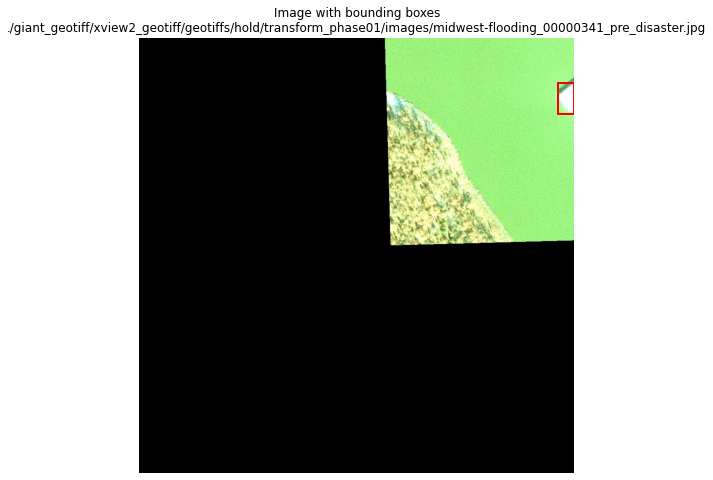

In [25]:
display_image_with_bboxes(
    image_path='./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000341_pre_disaster.jpg',
    csv_path='./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/midwest-flooding_00000341_pre_disaster.csv'
)

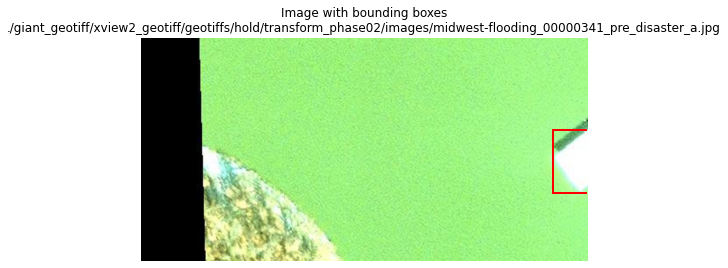

In [26]:
display_image_with_bboxes(
    image_path='./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/images/midwest-flooding_00000341_pre_disaster_a.jpg',
    csv_path='./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase02/label-csvs/midwest-flooding_00000341_pre_disaster_a.csv'
)